*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall22/notebooks/module06_02_esnemble_methods.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Ensemble methods


Ensemble methods are machine learning methods that base their predictions on a collection of classifiers.  Each individual classifier might not have high accuracy, but by taking a "vote" among a diverse set, it is possible to obtain much higher accuracy than that of any member of the ensemble.
This idea can be traced all the way back to the work of British scientist Sir Francis Galton.
He discovered in the early 1900s that a collection of educated guesses can add up to very accurate predictions.
This has been termed as **the wisdom of crowds**, and was described in the following publication:

> Francis Galton. [Vox Populi](http://galton.org/essays/1900-1911/galton-1907-vox-populi.pdf).  Nature 75, pages 450-451, 1907.

Our intuition of why this works is that averaging of many independent and diverse measurements can lead to more reliable estimates.  The central limit theorem in statistics is a mathematical statement of that fact.

Let us illustrate the potential benefit of this idea by a simulation study.  Let's consider a set of five classifiers, each of which is right 70% of the time and see how voting increases accuracy.


In [10]:
# the following example inspired by code from
# http://ethen8181.github.io/machine-learning/trees/random_forest.html

from numpy.random import default_rng
rng = default_rng()

# generate random labels
y = rng.choice([0,1], size=(1000,))

accuracy = 0.7
num_classifiers = 5

# each classifier mutates a fraction of the labels 
# according to the accuracy
predictions = []
for i in range(num_classifiers):
    predictions.append([y[i] if rng.random() < accuracy else 1-y[i] for i in range(len(y))])
predictions = np.array(predictions)  

In [11]:
# accuracy of individual classifiers:
for i in range(num_classifiers):
    print('accuracy: ', np.mean(predictions[i] == y))

accuracy:  0.689
accuracy:  0.693
accuracy:  0.689
accuracy:  0.716
accuracy:  0.717


In [12]:
# generate the predictions of the ensemble:
ensemble_predictions = np.round(np.sum(predictions, axis=0) / num_classifiers)
# accuracy of the voted classifier:
np.mean(ensemble_predictions == y)

0.829

As you can see, the accuracy increases as the number of models increases.
This result is an example of the [Condorcet's Jury Theorem](http://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem).
This idea can be applied for real machine learning problems.  All we need is an **ensemble of diverse models from the same training data**.  We will discuss several ways of achieving this goal.  The general strategy for constructing ensemble classifiers is as follows:

* Construct a collection diverse predictive models by tweaking the training data
* Combine the predictions of the models, e.g. by voting

The simplest implementation of this idea is through the strategy known as "bagging", which is described next.

### Bagging

Bagging (**b**ootstrap **agg**regat**ing**) is a simple ensemble method based on the concept of a **bootstrap sample**.

**Bootstrap sample:**  a sample with replacement from a dataset.

For example:

In [13]:
sample = rng.choice(range(10), size=(10), replace=True)
sample

array([2, 6, 9, 7, 5, 3, 2, 6, 8, 8])

In a bootstrap sample, the probability that a given example is not selected when taking a bootstrap sample of size $N$ is $(1 - \frac{1}{N})^N$.  This has a limit as $N$ goes to infinity which is equal to 
$1/e = 0.368$.  From this observation we can conclude that each bootstrap sample is likely to leave out about a third of the examples.


**Bagging** ($\mathcal{D}$, $\mathcal{A}$, $T$)

Input:  labeled dataset $\mathcal{D}$, learning algorithm $\mathcal{A}$, ensemble size $T$.

Output:  ensemble of models whose predictions are combined by voting/averaging

* for $t = 1,...,T$

* build bootstrap sample $\mathcal{D}_t$ by sampling $N$ data points with replacement from $\mathcal{D}$
* train $\mathcal{A}$ on $\mathcal{D}_t$ to produce a model $\mathcal{M}_t$.

return $\mathcal{M}_1,\ldots,\mathcal{M}_T$.

The algorithm was described in the following publication:

> Breiman, Leo (1996). "Bagging predictors”. Machine Learning 24 (2): 123–140.

### Random forests

Random forests are a special case of bagging with the following additional features:
* Use decision trees as the base classifier
* At each split in the decision tree, choose a subset of features from which to choose the split on.

As we discussed, decision trees can be unstable with respect to perturbations of the training data.  This is not a desirable property from a learning algorithm, but is actually useful as a component in an ensemble classifier.
Sampling the features serves to further increase the diversity of the resulting classifiers.  

<img style="padding: 10px; float:center;" alt="CC BY-SA 4.0
 by Venkata Jagannath - https://community.tibco.com/wiki/random-forest-template-tibco-spotfirer-wiki-page" src="https://upload.wikimedia.org/wikipedia/commons/7/76/Random_forest_diagram_complete.png" width="300">



**Random Forests** ($\mathcal{D}$, $T$, num_features)

Input:  labeled dataset $\mathcal{D}$, ensemble size $T$, and num_features, the number of features to sample for each tree.

Output:  ensemble of models whose predictions are combined by voting/averaging

* for $t = 1,...,T$

* build bootstrap sample $\mathcal{D}_t$ by sampling $N$ data points with replacement from $\mathcal{D}$
* train a decision tree on $\mathcal{D}_t$ where each split is chosen on the basis of `num_features` random features; produce a model $\mathcal{M}_t$.

return $\mathcal{M}_1,\ldots,\mathcal{M}_T$.

Random forests is one of the most important methods in machine learning.  The method was described in the following publication:


> Random forests.  L Breiman.  Machine Learning, 2001.

As a first step, we will explore the shape of the decision boundary of random forests and compare it to that of decision trees.

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [15]:
def visualize_classifier(model, X, y, ax=None, cmap='viridis'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, alpha=0.6, zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
                           zorder=1)


In [16]:
from sklearn.datasets import load_iris
iris = load_iris()
features = [0,1]
X = iris.data[:, features]
y = iris.target

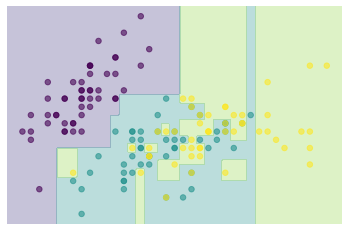

In [17]:
tree = DecisionTreeClassifier()
visualize_classifier(tree, X, y)

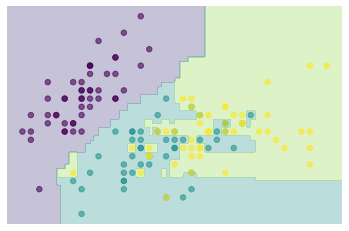

In [18]:
rf = RandomForestClassifier()
visualize_classifier(rf, X, y)

### Question

What do you observe is different about the random forests decision boundary?  Can you explain why that is?

### Accuracy comparison of random forests and decision trees

We will demonstrate the accuracy advantage of random forests using a dataset whose number of features is larger than the number of training examples.  This is very common in biological datasets. this using a dataset describing the activity of a large number of genes, from which disease state can be inferred.  The particular dataset we will analyze looks at biological samples taken from leukemia patients with two types of leukemia: acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).  The data was taken from the following publication:

> Golub, Todd R., et al. "Molecular classification of cancer: class discovery and class prediction by gene expression monitoring." Science  (1999): 531-537.

In [19]:
import requests
# if you don't have requests installed you can use urlopen which is part
# of the python standard library
# from urllib.request import urlopen

link = "https://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv"
# retrieve the contents of the file
contents = requests.get(link)

In [20]:
lines = contents.text.split()
# the data is in csv format and the labels appear in the first 
# row of the dataset:
print (lines[0])
class_convert = {'ALL':1, 'AML':0}
y = np.array([class_convert[token] for token in lines[0].split(',')])
X = np.array([ [float(token) for token in line.split(',')] 
              for line in lines[1:] ])
X = X.transpose()
X.shape,y.shape

ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML


((72, 7128), (72,))

In [21]:
classifier = DecisionTreeClassifier()

cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
accuracy = cross_val_score(classifier, X, y, cv=cv, scoring='accuracy')
round(np.mean(accuracy), 3)

0.749

Next, let us apply random forests and observe the improvment in accuracy:

In [22]:
classifier = RandomForestClassifier(n_estimators=100)

accuracy = cross_val_score(classifier, X, y, cv=cv, scoring='accuracy')
round(np.mean(accuracy), 3)

0.972

As you can see from our next experiment, random forests works better than bagging on this dataset:

In [23]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(DecisionTreeClassifier(), 
                        n_estimators=100)
accuracy = cross_val_score(bag, X, y, cv=cv, scoring='accuracy')
round(np.mean(accuracy), 3)                          

0.93

### Additional features of random forests

Random forests have additional features that are worth noting: 

* Error estimation during training using out-of-bag data.  Out of bag data are examples that were not selected in a given bootstrap sample.
* Variable importance; random forests also generates a score for each feature according to its contribution to accuracy on out-of-bag examples.


### Related methods:  boosting

Boosting is similar to bagging, but uses a more sophisticated method for constructing its diverse training sets.
Boosting classifiers are constructed iteratively and the main idea is to focus training of the next classifier on examples that previous classifiers made errors on.
Furthermore, each classifier is assigned a confidence value that depends on its accuracy.
The gradient boosting flavor of this method, along with random forests, were shown to achieve state-of-the accuracy on many problems.

### Summary

* Bagging and random forests provide a big improvement in accuracy over decision trees.
* Training and prediction are fast.  The method is highly parallelizable.
* Very flexible model, and yet not very susceptible to overfitting.
* Able to handle missing data.
* Useful variable importance measure obtained as part of the training procedure.
* Works well out of the box, and is a good baseline classifier.

Research has shown that random forests is one of the best classifiers available.  In a 2014 comparison of a large selection of methods, random forests and SVMs have demonstrated themselves as the two best options.  See:

> Fernández-Delgado, Manuel, et al. "[Do we need hundreds of classifiers to solve real world classification problems?](https://jmlr.csail.mit.edu/papers/volume15/delgado14a/delgado14a.pdf)." The journal of machine learning research 15.1 (2014): 3133-3181.

However, note that this was before the era of deep learning, and for rather standard prediction problems.